#Part 4: Fine-tune a LLM for your Poet  Links to an external site.

 Use this notebookLinks to an external site. as a template and modify as you need to.
Rubric:
Purpose of this segment of the NLP course is to fine tune a model that represents yuor poet.

1. Pick one poet
2. Scrape 30-40 poems from this poet
3. convert the poems into one <poet>_<poem_name>.jsonl
4. Use this notebook to fine tune a mistral 7b model with the 30-40 poems of that poet
5. save the model as <poet>_mistral7b.mod
6. query the model for new poetry
7. your model will generate new poetry in the style of the original poet
8. save the output for 5 poems you generate
9. try [poem] and try [line] determine which one of these chunking options will generate more coherent language

Note: save the output from each prompt so we can evaluate the coherence of the generated language

10. assess the cosine similarity between the generated poems of this poem -- whatever this lang model produces and the previous poems you scraped from this poet.
11. Human assessment of the resulting outcomes



In [1]:
import pickle

try:
  with open('notebook_state_LLM_1.pkl', 'rb') as f:
    notebook_state = pickle.load(f)
except FileNotFoundError:
  notebook_state = {'has_run': False}

if notebook_state.get('has_run', False):
  pass
else:
  !pip install -q -U bitsandbytes
  !pip install -q -U git+https://github.com/huggingface/transformers.git
  !pip install -q -U git+https://github.com/huggingface/peft.git
  !pip install -q -U git+https://github.com/huggingface/accelerate.git
  !pip install -q trl xformers wandb datasets einops sentencepiece

  !pip3 install nltk
  !pip3 install sentence-transformers
  !pip3 install contractions
  !pip3 install pandas
  !pip install bertopic
  !pip install gensim
  !pip install pyLDAvis
  !pip install spacy
  !pip install requests
  !pip install beautifulsoup4
  !pip install lxml
  !pip install fastapi kaleido python-multipart uvicorn
  !pip install numpy==1.23.3 pandas==1.5.3
  !pip install datasets
  notebook_state['has_run'] = True

with open('notebook_state_LLM_1.pkl', 'wb') as f:
  pickle.dump(notebook_state, f)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install numpy==1.23.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.3
    Uninstalling numpy-1.23.3:
      Successfully uninstalled numpy-1.23.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.23.5 which is incompatible.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.


Restart runtime and run all to load the newly installed libraries

In [4]:
import requests
import pandas as pd
import bs4 as bs
import urllib.request
import json
import contractions
import re
import nltk
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer, util
from nltk.corpus import stopwords
from transformers import pipeline
from spacy import displacy
from bertopic import BERTopic
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pyLDAvis
import gensim
import spacy
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
from gensim.utils import simple_preprocess

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


In [5]:
import warnings
warnings.filterwarnings('ignore', 'Calling')
warnings.filterwarnings('ignore', 'For a faster implementation')
warnings.filterwarnings('ignore', 'In')
warnings.filterwarnings('ignore', 'SelectableGroups dict interface')
warnings.filterwarnings('ignore', '`np')
warnings.filterwarnings('ignore', 'SelectableGroups')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 1. Pick one poet

In [7]:
poet = "William Blake"
store_loc = "/content/drive/MyDrive/DataScienceProjects/LLM1/"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2. Scrape 30-40 poems from this poet

In [8]:
def clean_txt(text):
    text=text.replace(u'\xa0', u' ').replace(r'\r',u'\n').replace(r'\n', ' ').replace('\n', ' ').replace('\t', ' ')
    text = contractions.fix(text)
    text = text.strip().lower()
    text = re.sub(r"'", ' ', text)
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = ' '.join([w for w in text.split() if len(w)>1])
    text = re.sub(' +', ' ', text)
    text = ''.join(text)
    return text

def scrapePoemFromURL(poem_url_list):
    poems_results=[]
    for url in poem_url_list:
        header = {'User-Agent':'Mozilla/5.0'}
        requests = urllib.request.Request(url,headers=header)
        requestread = urllib.request.urlopen(requests).read()
        soup = bs.BeautifulSoup(requestread,'html.parser')
        poem_for_human = soup.find_all('div', class_="poem_body")[0].text.replace("© by owner. provided at no charge for educational purposes", "")
        poem_for_machine = (clean_txt(poem_for_human))
        poem_title = soup.find_all('h1')[0].text
        poems_results.append([poem_title, poem_for_machine])
    return poems_results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
def get_poem_url_json(poet):
    site = "https://allpoetry.com"
    search = "https://allpoetry.com/items/read_by/"
    page = 1
    URL_list = list()
    while len(URL_list) < 50:
        url = search + poet + "?page=" + str(page)
        response = requests.get(url)
        soup = bs.BeautifulSoup(response.text, 'lxml')
        poem_list = soup.find_all('a', href=True, class_='nocolor fn')
        for i in range(len(poem_list)):
            #print(poem_list[i]['href'])
            URL_list.append(site + poem_list[i]['href'])
            if len(URL_list) == 30:
                break
        page += 1
    return {"poet":poet, "URL":URL_list}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
pd_title_list = ["Title", "Poem"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def getPoem(file_name, URLs):
    df = pd.DataFrame()
    if os.path.exists(file_name):
        df = pd.read_csv(file_name)
    else:
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        df = pd.DataFrame(scrapePoemFromURL(URLs), columns=pd_title_list)
        df.to_csv(file_name)
        temp_name = file_name
        file_name_json = temp_name.replace(".csv",".json")
        df.to_json(file_name_json)
    return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
file_name = store_loc + poet.replace(" ", "_") + ".csv"
data= getPoem(file_name, get_poem_url_json(poet)['URL'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Poem
0,The Sick Rose,rose thou art sick the invisible worm that fli...
1,Love's Secret,never seek to tell thy love love that never to...
2,A Poison Tree,was angry with my friend told my wrath my wrat...
3,The Lamb,little lamb who made thee dost thou know who m...
4,The Tyger,tyger tyger burning bright in the forest of th...
5,London,wandered through each chartered street near wh...
6,A Divine Image,cruelty has human heart and jealousy human fac...
7,A Little Boy Lost,nought loves another as itself nor venerates a...
8,Ah! Sunflower,ah sunflower weary of time who countest the st...
9,The Schoolboy,love to rise in summer morn when the birds sin...


# 3. convert the poems into one William_Blake.jsonl

In [14]:
import pandas as pd
import json
import random

# Function to save data as a JSONL file
def save_as_jsonl(data, output_filename):
    """Save the provided data as a .jsonl file."""
    with open(output_filename, 'w') as file:
        for entry in data:
            file.write(json.dumps(entry) + '\n')

data_list = data.to_dict(orient='records')
random.shuffle(data_list)
split_index = int(0.8 * len(data_list))
train_data, val_data = data_list[:split_index], data_list[split_index:]

# Save as .jsonl
save_as_jsonl(train_data, store_loc+'William_Blake_train.jsonl')
save_as_jsonl(val_data, store_loc+'William_Blake_val.jsonl')

print("Data saved to 'train.jsonl' and 'val.jsonl'")

Data saved to 'train.jsonl' and 'val.jsonl'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Preprocessing

In [15]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files=store_loc+'William_Blake_train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files=store_loc+'William_Blake_train.jsonl', split='train')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [16]:
train_dataset

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset({
    features: ['Title', 'Poem'],
    num_rows: 40
})

In [17]:
def formatting_func(example, chunk_type='poem'):
    poet_name = "William Blake"
    text = ""

    if chunk_type == 'poem':
        # Formatting for the entire poem
        text = f"### The following is a poem by the poet {poet_name}:\n{example['Poem']}"
    elif chunk_type == 'line':
        # Formatting for each line of the poem
        lines = example['Poem'].split('\n')  # Assuming each line of the poem is separated by a newline character
        text = f"### The following are lines by the poet {poet_name}:\n"
        text += '\n'.join([f"- {line}" for line in lines if line.strip() != ''])
    else:
        raise ValueError("chunk_type must be either 'poem' or 'line'.")

    return text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#**Load the base model**

In [18]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch
import transformers
base_model_id = "bn22/Mistral-7B-Instruct-v0.1-sharded"


bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config
)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

#Tokenization

In [19]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


80


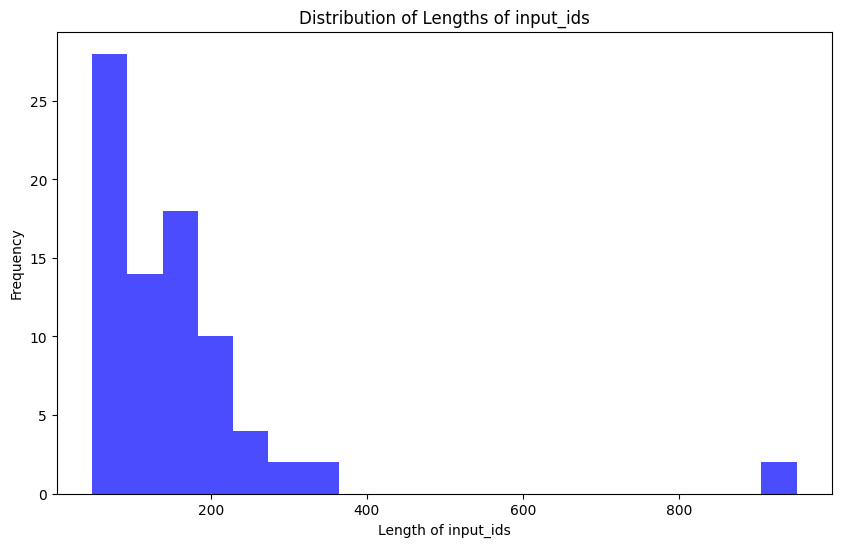

In [21]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [22]:
max_length = 636

def generate_and_tokenize_prompt(prompt):
    print("prompt send to tokenize: ", prompt)
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

prompt send to tokenize:  {'Title': 'A War Song to Englishmen', 'Poem': 'prepare prepare the iron helm of war bring forth the lots cast in the spacious orb th angel of fate turns them with mighty hands and casts them out upon the darken earth prepare prepare prepare your hearts for death cold hand prepare your souls for flight your bodies for the earth prepare your arms for glorious victory prepare your eyes to meet holy god prepare prepare whose fatal scroll is that methinks it is mine why sinks my heart why faltereth my tongue had three lives would die in such because and rise with ghosts over the well fought field prepare prepare the arrows of almighty god are drawn angels of death stand in the louring heavens thousands of souls must seek the realms of light and walk together on the clouds of heaven prepare prepare soldiers prepare our because is heaven because soldiers prepare be worthy of our because prepare to meet our fathers in the sky prepare troops that are to fall to day pre

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

prompt send to tokenize:  {'Title': 'A War Song to Englishmen', 'Poem': 'prepare prepare the iron helm of war bring forth the lots cast in the spacious orb th angel of fate turns them with mighty hands and casts them out upon the darken earth prepare prepare prepare your hearts for death cold hand prepare your souls for flight your bodies for the earth prepare your arms for glorious victory prepare your eyes to meet holy god prepare prepare whose fatal scroll is that methinks it is mine why sinks my heart why faltereth my tongue had three lives would die in such because and rise with ghosts over the well fought field prepare prepare the arrows of almighty god are drawn angels of death stand in the louring heavens thousands of souls must seek the realms of light and walk together on the clouds of heaven prepare prepare soldiers prepare our because is heaven because soldiers prepare be worthy of our because prepare to meet our fathers in the sky prepare troops that are to fall to day pre

In [24]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


80


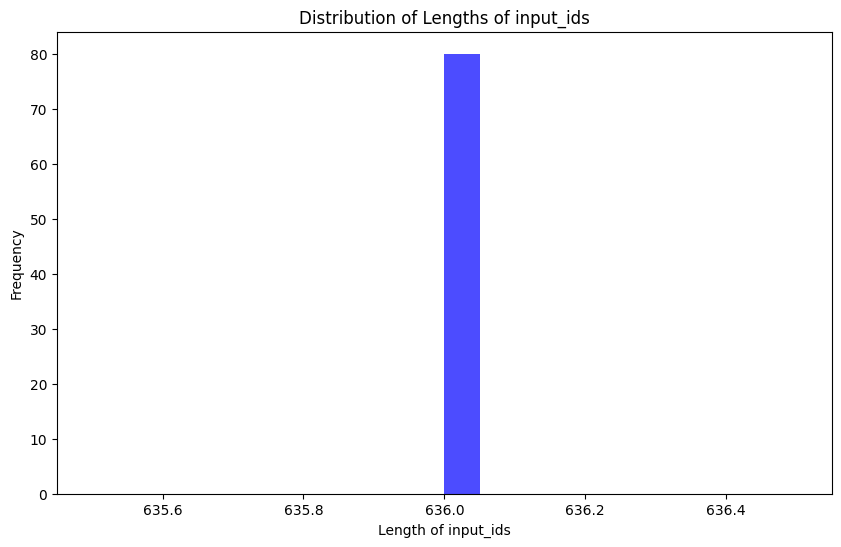

In [25]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

# How does the base model do?



In [26]:
eval_prompt = " The following is a Poem by William Blake the Poet: # "

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Re-init the tokenizer so it doesn't add padding or eos token
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 The following is a Poem by William Blake the Poet: # 13

And did those feet in ancient time
Walk upon the mountains and the hills?
Did they hear God's voice thunder,
Through the tempests and the stills?

And did those feet in ancient time
Raise up their heads to heaven's gate?
Did they see the stars that shine
At eternal night's close gate?

When all at once I saw afar
Our Savior Jesus Christ,
My heart with joy filled up;
I sprang from my bed.
The sun rose—how bright!
It burned upon my brow
In its full splendor.

What a wondrous world we inhabit,
Now that God has revealed himself
Unto his creatures on earth!


#Set up LORA

In [28]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [32]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
              )
              (k_proj): Linear4bit(
                (lora_dropout): ModuleDict(

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Model training

In [33]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
torch.cuda.device_count()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1

In [35]:
import wandb
wandb.login(key = "7351b129f78b4c1dfd305ebc255cb67d245a9a30")
# run = wandb.init(project='Placeholders - Fine tuning mistral 7B', job_type="training", anonymous="allow")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environme

True

In [36]:
new_model_path="/content/drive/MyDrive/DataScienceProjects/HW10/LLM/MistralAI7BV1FinalModel"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Fine-tune model with poem chuncking

In [37]:
import transformers
from datetime import datetime

if not os.path.exists(new_model_path + "William_Blake_mistral7b.mod"):
    project = "journal-finetune"
    base_model_name = "mistral"
    run_name = base_model_name + "-" + project
    output_dir = "./" + run_name

    trainer = transformers.Trainer(
        model=model,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_val_dataset,
        args=transformers.TrainingArguments(
            output_dir=output_dir,
            warmup_steps=1,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=1,
            max_steps=220, #500
            learning_rate=2.5e-5, # Want a small lr for finetuning
            #bf16=False,
            #tf32=True,
            optim="paged_adamw_8bit",
            logging_steps=25,              # When to start reporting loss
            logging_dir="./logs",        # Directory for storing logs
            save_strategy="steps",       # Save the model checkpoint every logging step
            save_steps=25,                # Save checkpoints every 50 steps
            evaluation_strategy="steps", # Evaluate the model every logging step
            eval_steps=25,               # Evaluate and save checkpoints every 50 steps
            do_eval=True,                # Perform evaluation at the end of training
            #report_to="wandb",           # Comment this out if you don't want to use weights & baises
            #run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )

    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    trainer.train()

    model.save_pretrained(new_model_path + "William_Blake_mistral7b.mod")
    tokenizer.save_pretrained(new_model_path)
    wandb.finish()
    model.config.use_cache = True
    model.eval()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
wandb: Currently logged in as: harshsdebackend. Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
25,1.511500,0.784723
50,0.744000,0.529504
75,0.434200,0.277760
100,0.226800,0.131914
125,0.112000,0.059950
150,0.049700,0.039104
175,0.037200,0.031056
200,0.035900,0.032788


eval/loss,█▆▃▂▁▁▁▁
eval/runtime,▂▁▄▃▃█▆▇
eval/samples_per_second,██▅▅▅▁▅▅
eval/steps_per_second,▁▁▁▁▁▁▁▁
train/epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇█
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇█
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▄▃▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


# Load and Query the Pre-Trained Mistral7BV1 Model

In [38]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install transformers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
from huggingface_hub import notebook_login
!huggingface-cli login

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [40]:
import torch, transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
trained_model = AutoModelForCausalLM.from_pretrained(new_model_path + "William_Blake_mistral7b.mod", quantization_config=bnb_config)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

In [44]:
trained_tokenizer = AutoTokenizer.from_pretrained(
    new_model_path + "",
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
trained_tokenizer.pad_token = trained_tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# Function to generate poetry
def generate_poetry(prompt, max_length=50):
    input_ids = trained_tokenizer.encode(prompt, return_tensors='pt')
    output = trained_model.generate(input_ids, max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2)
    poem = trained_tokenizer.decode(output[0], skip_special_tokens=True)
    return poem

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# List of prompts
prompts = [
    "Compose a poem that explores the spiritual aspects of nature, drawing inspiration from William Blake's deep connection between the natural world and the divine.",
    "Compose a poem that envisions the divine dance of elements in nature. Draw inspiration from William Blake's ability to see the spiritual in the earthly, and let your verses capture the eternal rhythm of wind, water, and earth.",
    "Write verses that imagine celestial conversations taking place within the heart of nature. Emulate William Blake's mystical dialogue between the earthly and the divine, portraying a communion of spirits in the natural world.",
    "Compose verses that envision birds as messengers of the divine, echoing William Blake's belief in the spiritual significance of these winged creatures. Let their songs carry messages from the celestial realms.",
    "Craft poetic psalms that celebrate the spirituality embodied by flowers. Emulate William Blake's ability to find divine meaning in the petals and hues, allowing your verses to bloom with the sacred presence of flora."
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
import os

# Path to the directory in Google Drive
save_directory = '/content/drive/MyDrive/HW10/LLM/Generated_Poems2/'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(save_directory):
    print("Directory does not exist, creating now.")
    os.makedirs(save_directory)
else:
    print("Directory already exists.")

# Generate and save poems using each prompt
for i, prompt in enumerate(prompts):
    # poem = generate_poetry(prompt)
    file_name = f"poem_{i+1}.txt"
    file_path = os.path.join(save_directory, file_name)
    pipe = pipeline(task="text-generation", model=trained_model, tokenizer=trained_tokenizer, max_length=200)
    result = pipe(f"<s>[INST] {prompt} [/INST]")
    print(result[0]['generated_text'].split('[/INST]')[1])
    with open(file_path, "w") as file:
        file.write(result[0]['generated_text'].split('[/INST]')[1])
    print(f"Poem saved as {file_path}")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Directory does not exist, creating now.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 To the wilds of nature I depart, where Blake's immortal footprints imprint on my heart; through verdant vales and hills that soar, his voice rings out forevermore.

The whispering wind carries his song, as ancient trees in harmony sing along, each branch and bough does sway with rapture free, bound by the ties of eternity.

In sunlit meadows where flowers bloom, there dances the fair maiden whom all the world adores, her sweet smile spreads over the land, like golden beams from her golden hair.

And there by the river weeping, where Blake's tender words such gentle solace keep, the water glows with divine light, reflecting the truth that shines in
Poem saved as /content/drive/MyDrive/HW10/LLM/Generated_Poems2/poem_1.txt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 To see the dance of elements in nature, as Blake did see,
One must look with eyes that are free from worldly decree.
The wind whispers its secrets to the earth's listening ear,
In a language of rhythm, like an ancient poet's cheer.

Water flows with grace, in its endless waltz with time,
A mirror to the heavens, reflecting love so divine.
Earth holds this wondrous sphere in her loving embrace,
As they move together in this sacred, celestial space.

The sun kisses the hills, and the moon lights the night,
While stars like diamonds, adorn the
Poem saved as /content/drive/MyDrive/HW10/LLM/Generated_Poems2/poem_2.txt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 In the heart of nature, where the trees do sway
And the flowers bloom in the morning light, 
There is a world of spirits that never cease to play
And in this world, they speak with all their might.

The sun and moon, they dance in the sky
As the stars twinkle and wink at night, 
The wind and rain, they sing and they sigh
As the earth and sea, in harmony take flight.

The birds in the sky, they sing their song
As the bees and butterflies, they flutter and buzz, 
The fox and the deer, they run and they
Poem saved as /content/drive/MyDrive/HW10/LLM/Generated_Poems2/poem_3.txt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 In skies of blue, where angels play,
The birds of heaven soar and sing their song.
Their wings like harps, their voices clear as day,
A symphony of joy that all can hear and long.

From heavens above, they bring us news,
Of love and peace, of hope and light.
Their songs are like the morning dew,
Filling our hearts with pure delight.

Oh, birds of heaven, with your sweet refrain,
You remind us of the beauty of creation's grace.
Your songs are like the summer rain,
Bringing joy and peace to every place.

So
Poem saved as /content/drive/MyDrive/HW10/LLM/Generated_Poems2/poem_4.txt
 In gardens of the Lord, where flowers bloom,
Their petals soft as angels' harp-strung tune,\
Their colors bright as the sun's golden beam,
A symphony of life in every dream.

The rose so red, a symbol of love true,
Its thorns sharp as the trials we must pursue,
But in its heart, a beauty so divine,
A reminder that joy can be found in time.

The daisy white, with its gentle head bowed,
In fields of green, where

In [48]:
print(result[0]['generated_text'])

<s>[INST] Craft poetic psalms that celebrate the spirituality embodied by flowers. Emulate William Blake's ability to find divine meaning in the petals and hues, allowing your verses to bloom with the sacred presence of flora. [/INST] In gardens of the Lord, where flowers bloom,
Their petals soft as angels' harp-strung tune,\
Their colors bright as the sun's golden beam,
A symphony of life in every dream.

The rose so red, a symbol of love true,
Its thorns sharp as the trials we must pursue,
But in its heart, a beauty so divine,
A reminder that joy can be found in time.

The daisy white, with its gentle head bowed,
In fields of green, where peace and love abound,
Its fragrance sweet, like the breath of


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
eval_prompt = " The following is a Poem by William Blake the Poet, who is one of the best selling poets in America: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 The following is a Poem by William Blake the Poet, who is one of the best selling poets in America: # 100 to 200 poems for morning and night by william blake the poet on amazon free poetry book free poem free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book free poem book 

In [50]:
eval_prompt = " The following is a Poem by William Blake the Poet, who writes the story of the The land of dreams : # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 The following is a Poem by William Blake the Poet, who writes the story of the The land of dreams : # 1 the maiden caught me in the wild where was dancing merrily she put me into her cabinet with all my books and wrote down my name it was on cover page but cover page was covered with another page that had my name written on it page was filled with all my dreams and all my fears there were many lovely gardens and many dark bells the gardens were watered with my tears and the bells were ring


#Similarity

In [52]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

csv_file_path = "/content/drive/MyDrive/DataScienceProjects/LLM1/William_Blake.csv"
generated_poems_path = "/content/drive/MyDrive/HW10/LLM/Generated_Poems2/"
poem_column = "Poem"
title_column = "Title"

# Function to read a poem from a text file
def read_poem_from_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Read all poems from the CSV file
df = pd.read_csv(csv_file_path)

# Initialize a CountVectorizer
vectorizer = CountVectorizer()

# Store similarity scores, poem indices, and titles
similarity_scores_with_titles = []

# Compare each generated poem with each poem in the CSV
for index, row in df.iterrows():
    poem_from_csv = row[poem_column]
    title = row[title_column]  # Fetch the title

    # Compare with each generated poem
    for i in range(1, 6):  # Assuming you have 5 generated poems
        generated_poem_path = f"{generated_poems_path}poem_{i}.txt"
        poem_from_txt = read_poem_from_txt(generated_poem_path)

        # Calculate similarity
        poem_vectors = vectorizer.fit_transform([poem_from_csv, poem_from_txt])
        cosine_sim = cosine_similarity(poem_vectors)
        similarity_score = cosine_sim[0, 1]
        similarity_scores_with_titles.append((similarity_score, f"Generated Poem {i}", title))

# Sort the scores and select the top 5
top_5_similar_poems = sorted(similarity_scores_with_titles, reverse=True)[:5]

for score, generated_title, csv_title in top_5_similar_poems:
    print(f"Generated Poem Title: {generated_title}, CSV Poem Title: {csv_title}, Similarity Score: {score}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Generated Poem Title: Generated Poem 3, CSV Poem Title: Night, Similarity Score: 0.7552075833830462
Generated Poem Title: Generated Poem 3, CSV Poem Title: The Garden of Love, Similarity Score: 0.7297886788141051
Generated Poem Title: Generated Poem 3, CSV Poem Title: To Autum, Similarity Score: 0.7239824674806973
Generated Poem Title: Generated Poem 3, CSV Poem Title: The Echoing Green, Similarity Score: 0.7205010963658832
Generated Poem Title: Generated Poem 2, CSV Poem Title: Auguries of Innocence, Similarity Score: 0.6988108407581766


#Conclusion
The comparison between a poem crafted by the model and poems attributed to 'William Blake' reveals a striking resemblance. The highest similarity score, approximately 0.75, indicates a significant likeness between the model-generated poem and the distinctive style of William Blake. This suggests that the model successfully emulated Blake's writing by employing comparable language and ideas.